In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


2.2.0
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib 3.3.4
numpy 1.19.5
pandas 1.1.5
sklearn 0.24.2
tensorflow 2.2.0
tensorflow.keras 2.3.0-tf


In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [3]:
# x = (x - u) / std

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# x_train: [None, 28, 28] -> [None, 784]
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)


In [4]:
# tf.keras.models.Sequential()

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="selu"))
model.add(keras.layers.AlphaDropout(rate=0.2))
# AlphaDropout相对于普通Dropout优势: 1. 均值和方差不变 2. 归一化性质也不变
# model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer = keras.optimizers.SGD(0.001),
              metrics = ["accuracy"])

In [5]:
tf.random.set_seed(0)
# layer = tf.keras.layers.Dropout(.5, input_shape=(2,))
layer = tf.keras.layers.AlphaDropout(0.2, input_shape=(2,))  #改为0.2和0.1来查看效果
data = np.arange(1,13).reshape(6, 2).astype(np.float32)
print(data)

[[ 1.  2.]
 [ 3.  4.]
 [ 5.  6.]
 [ 7.  8.]
 [ 9. 10.]
 [11. 12.]]


In [6]:
outputs = layer(data, training=True)
print(outputs)

tf.Tensor(
[[ 1.1879435  2.066847 ]
 [ 2.9457507 -1.2361598]
 [-1.2361598  5.5824614]
 [ 6.461365   7.3402686]
 [ 8.219172  -1.2361598]
 [-1.2361598 10.855883 ]], shape=(6, 2), dtype=float32)


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               1

In [8]:
len(model.layers)

23

In [9]:
model.variables

[<tf.Variable 'dense/kernel:0' shape=(784, 100) dtype=float32, numpy=
 array([[-0.04861993,  0.00198571, -0.03432413, ..., -0.0157408 ,
          0.02780588,  0.04749313],
        [ 0.03318125,  0.06499209,  0.07688144, ...,  0.04919766,
          0.0062921 ,  0.03725569],
        [-0.04164748,  0.04069926,  0.07162932, ..., -0.06055954,
         -0.01139019,  0.00548374],
        ...,
        [ 0.02632346,  0.06221946, -0.06868462, ...,  0.01185537,
         -0.03735836,  0.07466032],
        [ 0.07596472, -0.06962536,  0.02282971, ..., -0.06583242,
         -0.02546909,  0.01004071],
        [ 0.01023196,  0.01298998, -0.06992787, ..., -0.03005658,
         -0.04336091,  0.04547527]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(100,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [10]:
# Tensorboard, earlystopping, ModelCheckpoint
logdir = './dnn-selu-dropout-callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir,
                                 "fashion_mnist_model.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,
                                    save_best_only = True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3),
]
history = model.fit(x_train_scaled, y_train, epochs=100,
                    validation_data=(x_valid_scaled, y_valid),
                    callbacks = callbacks)

Epoch 1/100
1719/1719 [==============================] - 16s 9ms/step - loss: 0.8656 - accuracy: 0.7034 - val_loss: 0.5631 - val_accuracy: 0.8180
Epoch 2/100
1719/1719 [==============================] - 15s 9ms/step - loss: 0.5693 - accuracy: 0.8044 - val_loss: 0.5237 - val_accuracy: 0.8366
Epoch 3/100
1719/1719 [==============================] - 15s 9ms/step - loss: 0.5002 - accuracy: 0.8266 - val_loss: 0.4826 - val_accuracy: 0.8468
Epoch 4/100
1719/1719 [==============================] - 15s 9ms/step - loss: 0.4580 - accuracy: 0.8399 - val_loss: 0.4619 - val_accuracy: 0.8534
Epoch 5/100
1719/1719 [==============================] - 15s 9ms/step - loss: 0.4292 - accuracy: 0.8490 - val_loss: 0.4310 - val_accuracy: 0.8632
Epoch 6/100
1719/1719 [==============================] - 15s 9ms/step - loss: 0.4044 - accuracy: 0.8564 - val_loss: 0.4157 - val_accuracy: 0.8682
Epoch 7/100
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3862 - accuracy: 0.8631 - val_loss: 0.4176 -

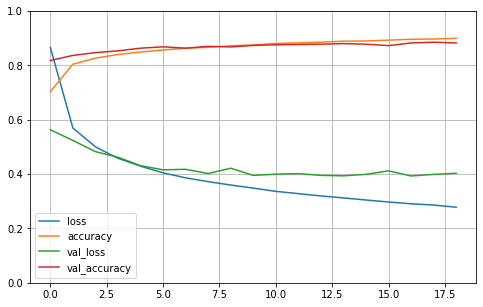

In [11]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

# 1. 参数众多，训练不充分
# 2. 梯度消失 -> 链式法则 -> 复合函数f(g(x))
#    selu缓解梯度消失

In [12]:
model.evaluate(x_test_scaled, y_test, verbose=0)

[0.437395304441452, 0.8697999715805054]